# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')

balance    25
dtype: int64


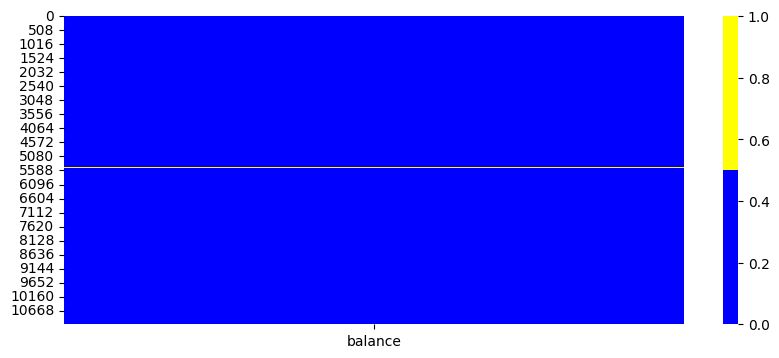

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
# тепловая карта пропусков
DATA = df

# количество пропусков в данных
cols_null_count = DATA.isnull().sum()
# Отфильтрованные колонки где есть пропуски
cols_with_null = cols_null_count[cols_null_count>0].sort_values(ascending=False)
# принт столбцов с пропусками и процентами пропусков
print(cols_with_null.apply(lambda x: round(x,2)))

# рисуем тепловую карту
colors = ['blue', 'yellow']
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
	DATA[cols].isnull(),
	cmap=sns.color_palette(colors),
)

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean()

1526.9360329690019

### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].apply(lambda s: df['job'].mode()[0] if s == 'unknown' else s)
df['education'] = df['education'].apply(lambda s: df['education'].mode()[0] if s == 'unknown' else s)

In [9]:
mask = (df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])
df[mask]['balance'].mean()

1598.8829787234042

### Задание 6

In [10]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Нижняя граница:',lower_bound)
    print('Верхняя граница:',upper_bound)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

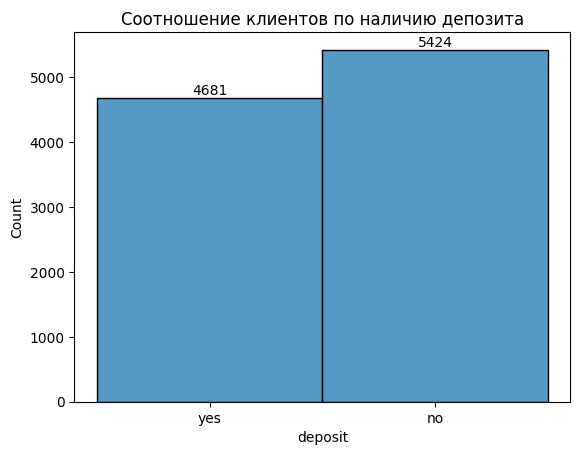

In [11]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
ax = sns.histplot(df['deposit'])
for p in ax.patches: 
    ax.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            p.get_height(), 
            ha='center',
            va='bottom')
ax.set_title('Соотношение клиентов по наличию депозита');

### Задания 2 и 3

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Большинство клиентов не имело контактов с банком до кампании

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


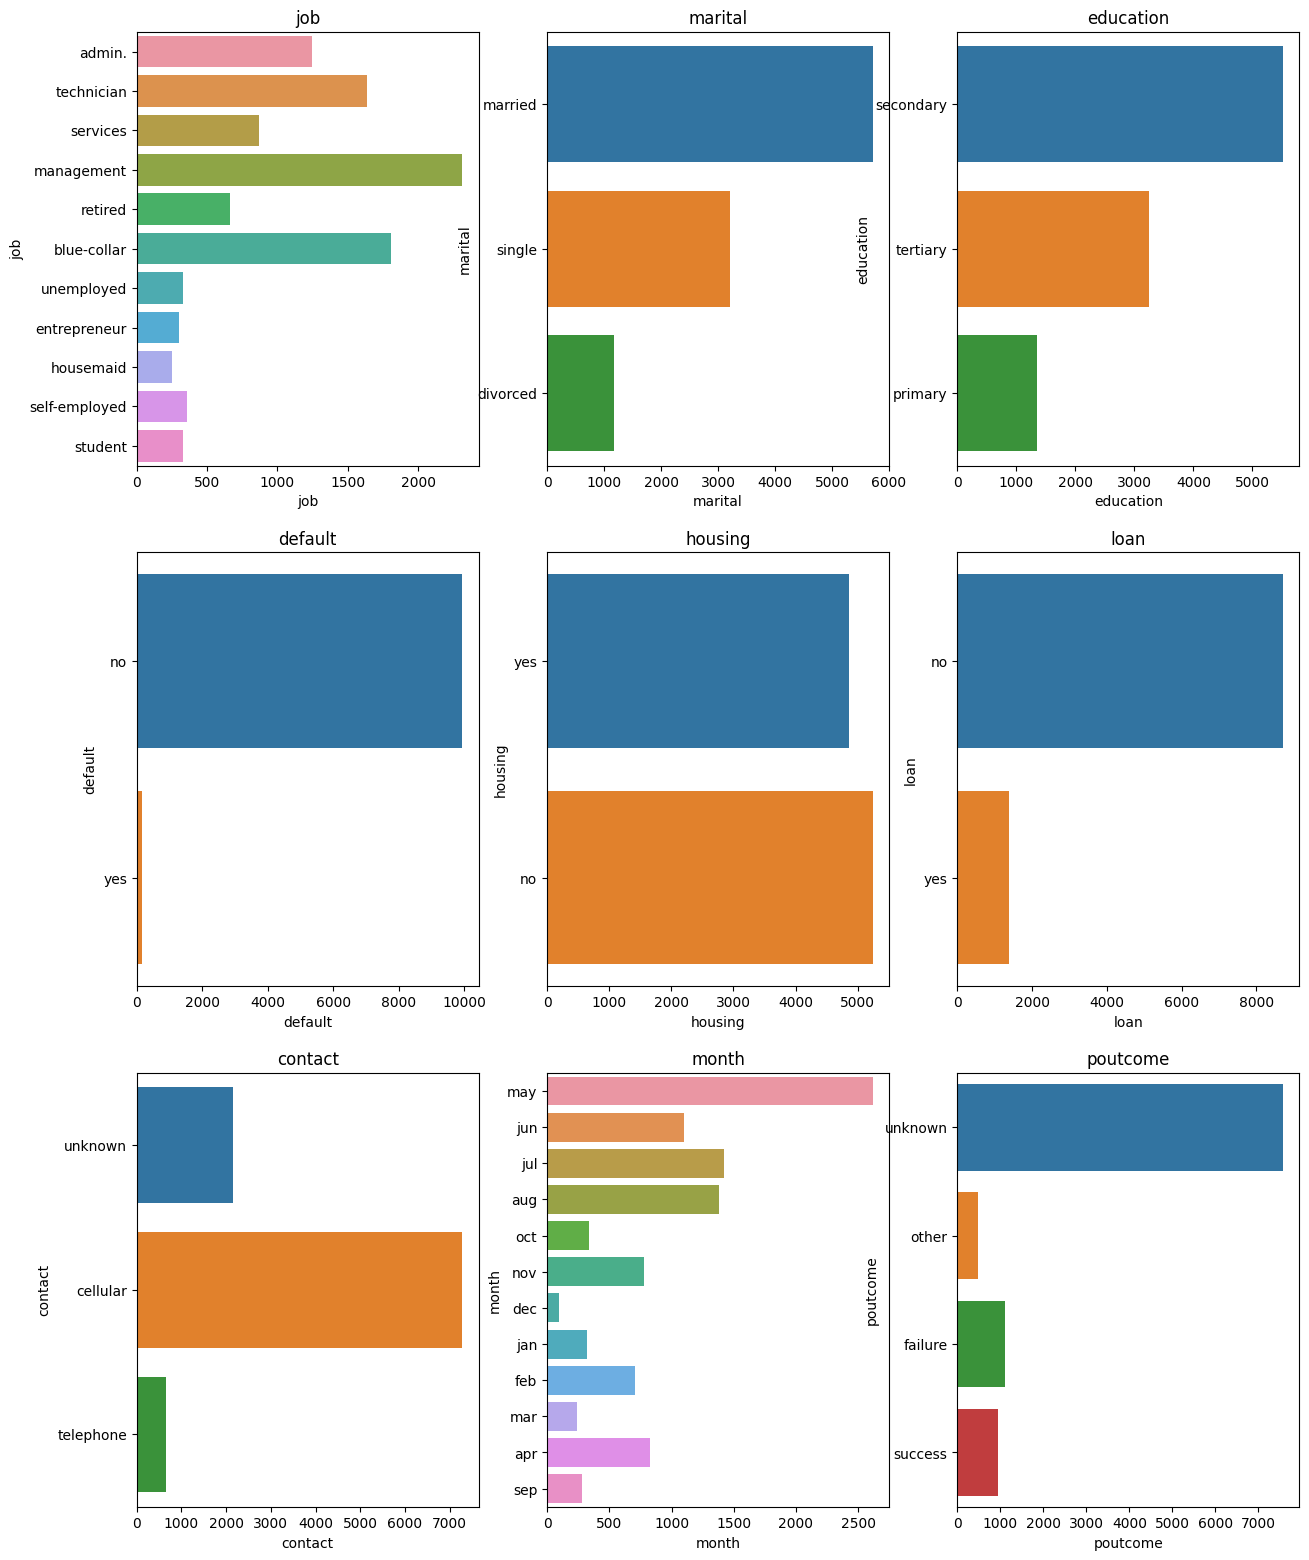

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
display(df.describe(include='object'))
categorical_features=[feature for feature in df.columns if ((df[feature].dtypes=='O') & (feature not in ['deposit']))]
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

### Задание 6

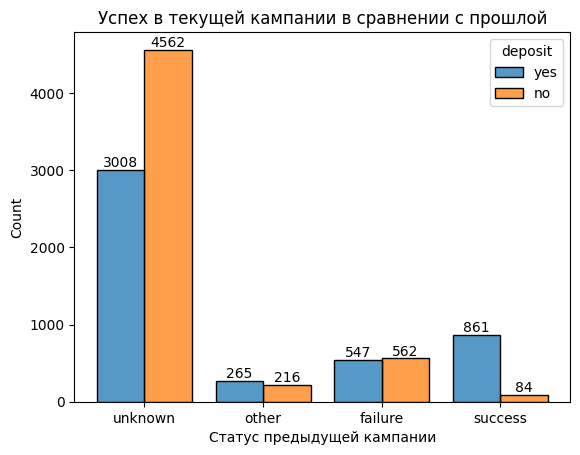

In [14]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
ax = sns.histplot(df,x='poutcome',hue='deposit',multiple='dodge',shrink=.8)
for p in ax.patches: 
    ax.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            p.get_height(), 
            ha='center',
            va='bottom')
ax.set_title('Успех в текущей кампании в сравнении с прошлой');
ax.set_xlabel('Статус предыдущей кампании');

### Задание 7

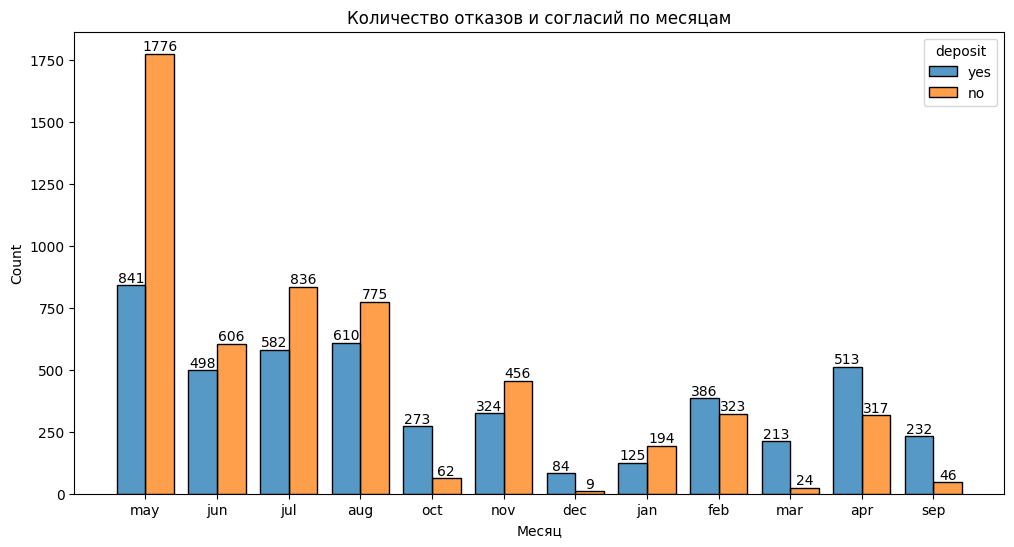

In [15]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(df,x='month',hue='deposit',multiple='dodge',shrink=.8)
for p in g.patches: 
    g.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            p.get_height(), 
            ha='center',
            va='bottom')
g.set_title('Количество отказов и согласий по месяцам');
g.set_xlabel('Месяц');

### Задание 8

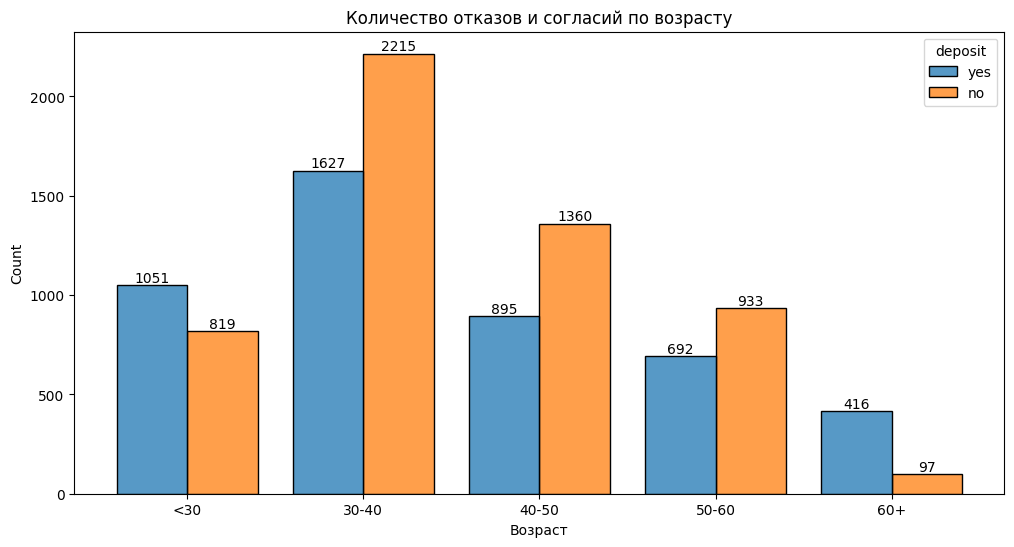

In [16]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

fig = plt.figure(figsize=(12, 6))
g = sns.histplot(df,x='age_group',hue='deposit',multiple='dodge',shrink=.8)
for p in g.patches: 
    g.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            p.get_height(), 
            ha='center',
            va='bottom')
g.set_title('Количество отказов и согласий по возрасту');
g.set_xlabel('Возраст');

### Задания 9 и 10

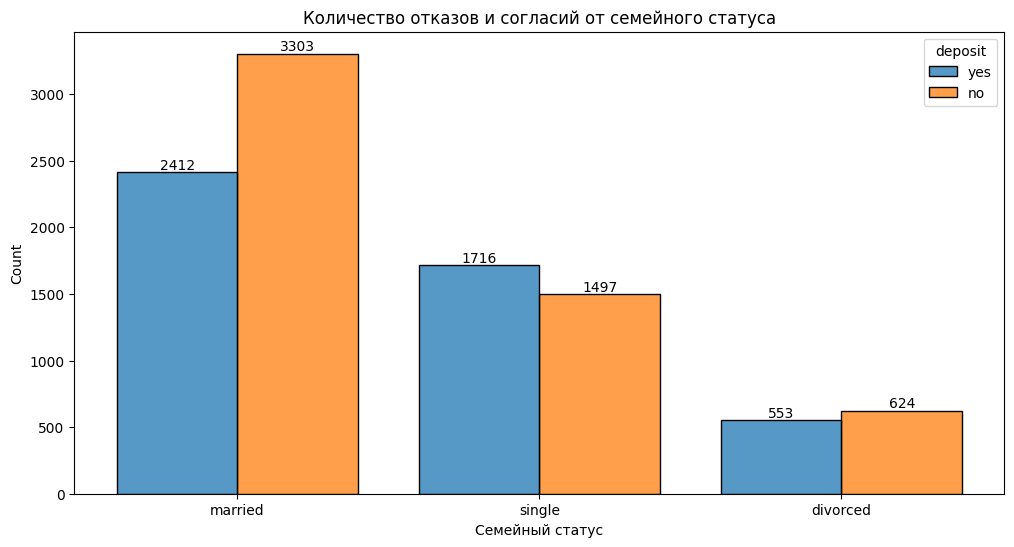

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(df,x='marital',hue='deposit',multiple='dodge',shrink=.8)
for p in g.patches: 
    g.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            p.get_height(), 
            ha='center',
            va='bottom')
g.set_title('Количество отказов и согласий от семейного статуса');
g.set_xlabel('Семейный статус');

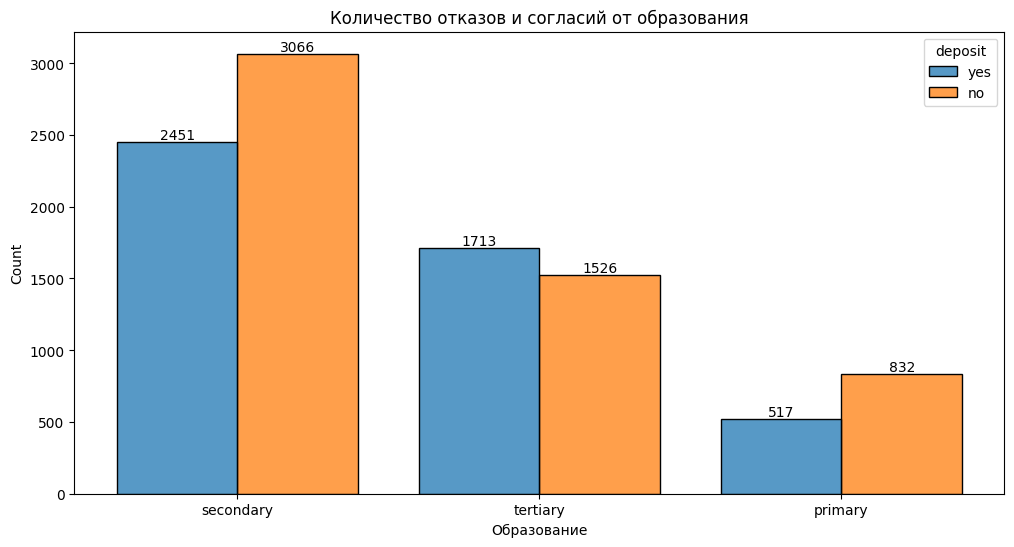

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(df,x='education',hue='deposit',multiple='dodge',shrink=.8)
for p in g.patches: 
    g.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            p.get_height(), 
            ha='center',
            va='bottom')
g.set_title('Количество отказов и согласий от образования');
g.set_xlabel('Образование');

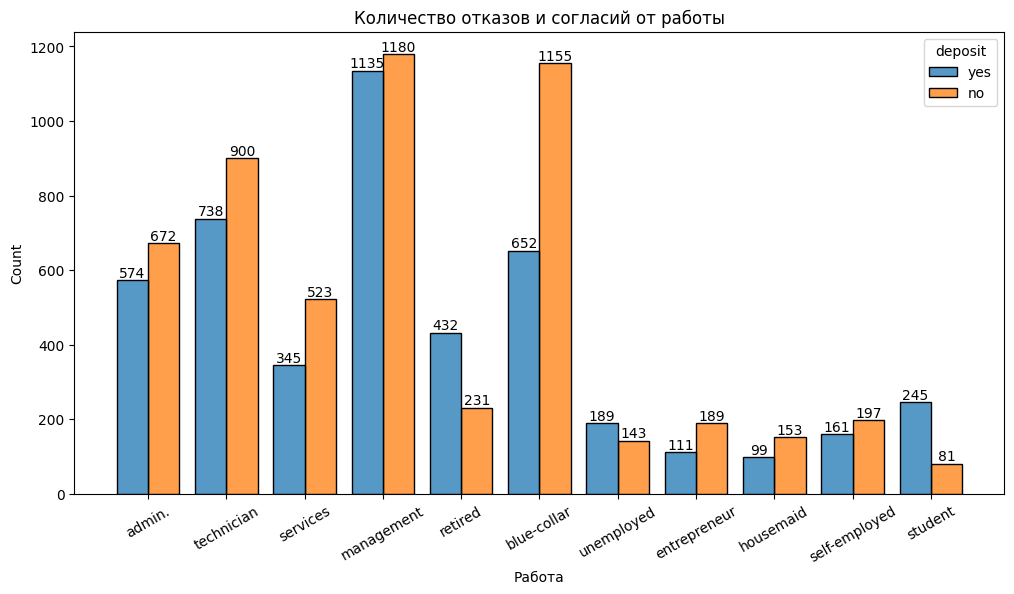

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = plt.figure(figsize=(12, 6))
g = sns.histplot(df,x='job',hue='deposit',multiple='dodge',shrink=.8)
for p in g.patches: 
    g.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            p.get_height(), 
            ha='center',
            va='bottom')
g.set_title('Количество отказов и согласий от работы');
g.set_xlabel('Работа');
g.xaxis.set_tick_params(rotation=30)

### Задание 11

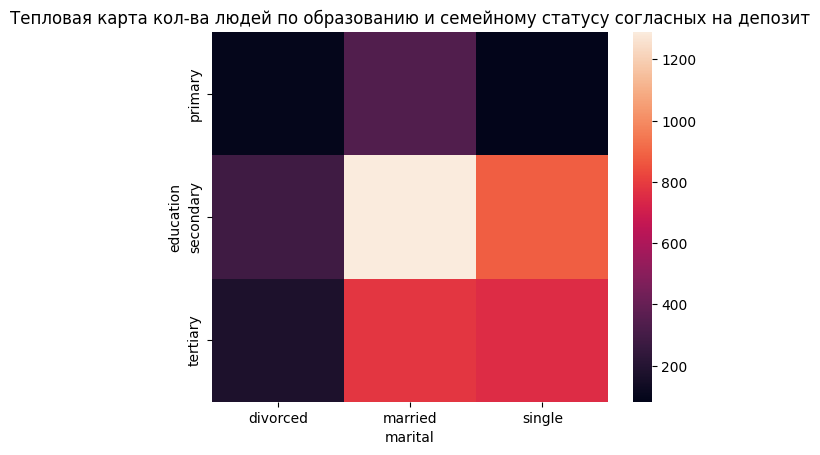

In [20]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
ax = sns.heatmap(df[df.deposit == 'yes'].pivot_table(columns='marital',index='education',aggfunc='count')['age'])
ax.set_title('Тепловая карта кол-ва людей по образованию и семейному статусу согласных на депозит');

## Часть 3: преобразование данных

### Задание 1

In [21]:
# преобразуйте уровни образования
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['education'].sum()

11995

In [22]:
le = LabelEncoder()
df["age_group"] = le.fit_transform(df["age_group"])

### Задания 2 и 3

In [23]:
# преобразуйте бинарные переменные в представление из нулей и единиц
bin_cat = ['default','housing','loan','deposit']
for cat in bin_cat:
    df[cat] = df[cat].apply(lambda s: 0 if s == 'no' else 1)
df[bin_cat]

,default,housing,loan,deposit
0,0,1,0,1
1,0,0,0,1
2,0,1,0,1
3,0,1,0,1
4,0,0,0,1
...,...,...,...,...
11157,0,1,0,0
11158,0,0,0,0
11159,0,0,0,0
11160,0,0,1,0


In [24]:
df['deposit'].std()

0.4986712532452124

### Задание 4

In [25]:
# создайте дамми-переменные
dumm_cat = ['job','marital','contact','month','poutcome']
dummies_data = pd.get_dummies(df[dumm_cat])
df = pd.concat([df,dummies_data],axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
3,55,services,married,1,0,2476.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
4,54,admin.,married,2,0,184.0,0,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True


In [26]:
df = df.drop(dumm_cat,axis=1)

### Задания 5 и 6

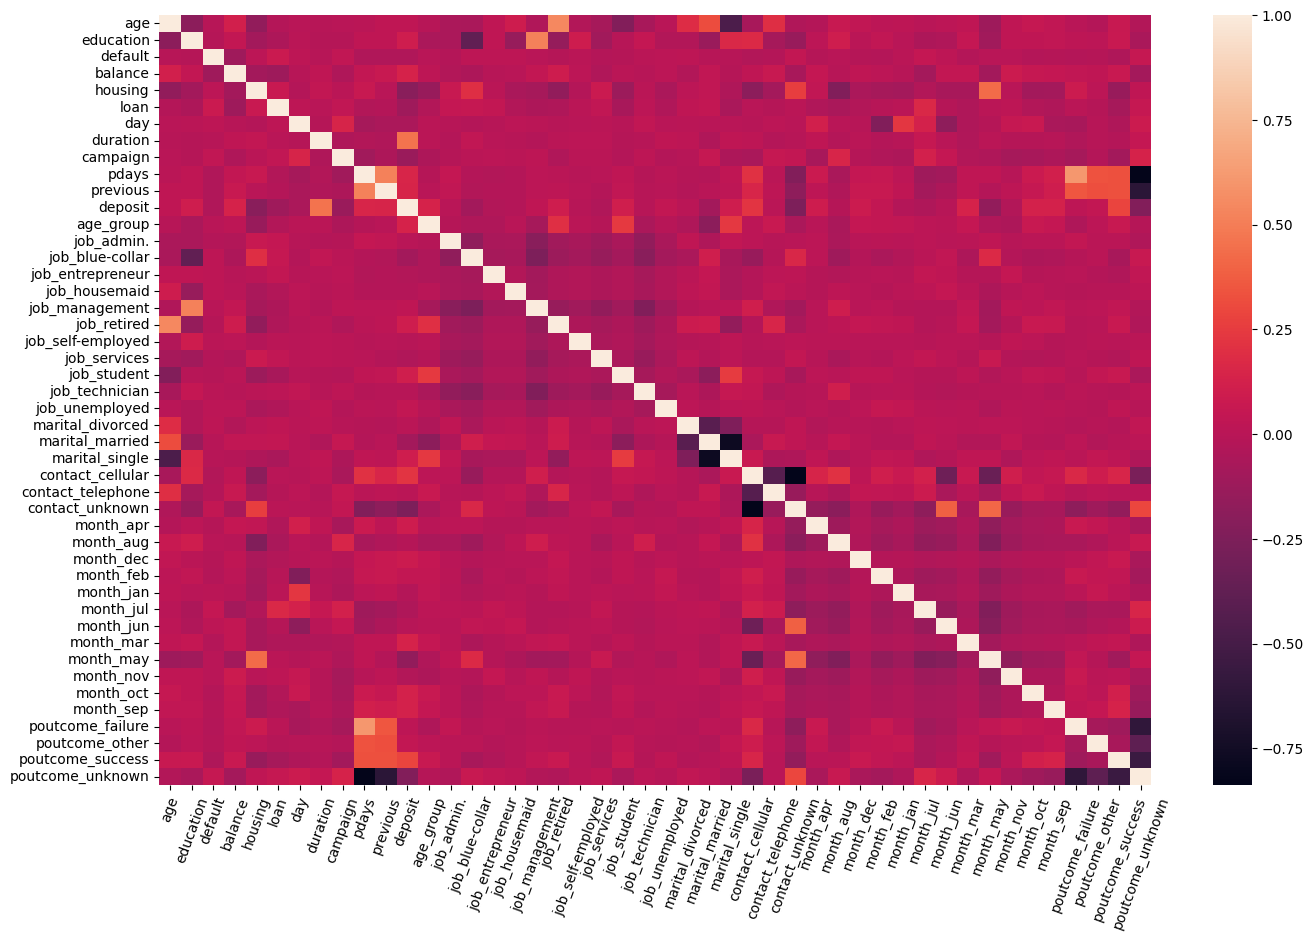

In [27]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig = plt.figure(figsize=(16, 10))
g = sns.heatmap(df.corr())
g.xaxis.set_tick_params(rotation=70)

### Задания 7 и 8

In [28]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 9

In [29]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [30]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown','deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [31]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled[:,0].mean()

0.46823674223097866

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [32]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag',random_state=42,max_iter=1000)

log_reg.fit(X_train_scaled,y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print('Train:\n',metrics.classification_report(y_train, y_train_pred))
print('Test:\n',metrics.classification_report(y_test, y_test_pred))

Train:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Test:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [33]:
# обучите решающие деревья, настройте максимальную глубину
dtc = tree.DecisionTreeClassifier(
    criterion='entropy',random_state=42)

dtc.fit(X_train_scaled,y_train)

y_train_pred = dtc.predict(X_train_scaled)
y_test_pred = dtc.predict(X_test_scaled)

print('Train:\n',metrics.classification_report(y_train, y_train_pred))
print('Test:\n',metrics.classification_report(y_test, y_test_pred))

Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Test:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



<Axes: xlabel='max depth'>

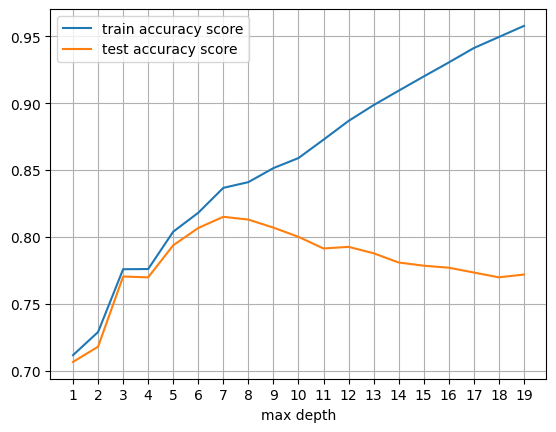

In [34]:
max_depth_list = np.arange(1,20)
train_acc_list = []
test_acc_list = []
for depth in max_depth_list:
    model = tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        max_depth=depth)
    
    model.fit(X_train_scaled,y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    train_acc_list.append(metrics.accuracy_score(y_train, y_train_pred))
    test_acc_list.append(metrics.accuracy_score(y_test, y_test_pred))

df_scores = pd.DataFrame(index=max_depth_list,data={'train accuracy score':train_acc_list,'test accuracy score':test_acc_list})
df_scores.plot(xlabel='max depth',xticks=np.arange(1,20),grid=True)

In [35]:
df_scores.loc[6]

train accuracy score    0.818021
test accuracy score     0.806597
Name: 6, dtype: float64

### Задание 5

In [187]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

GS_cv = GridSearchCV(
    tree.DecisionTreeClassifier(), 
    parameters, 
    scoring=('f1'), 
    return_train_score=True)

GS_cv.fit(X_train_scaled, y_train)
y_test_pred = GS_cv.predict(X_test_scaled)

print('Лучшие параметры: ',GS_cv.best_params_)

print('f1_score на тестовом: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Лучшие параметры:  {'max_depth': 7, 'min_samples_split': 2}
f1_score на тестовом: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [36]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

rf.fit(X_train_scaled, y_train)

y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

print('Train:\n',metrics.classification_report(y_train, y_train_pred))
print('Test:\n',metrics.classification_report(y_test, y_test_pred))

Train:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Test:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [38]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gbc = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

gbc.fit(X_train_scaled, y_train)

y_train_pred = gbc.predict(X_train_scaled)
y_test_pred = gbc.predict(X_test_scaled)

print('Train:\n',metrics.classification_report(y_train, y_train_pred))
print('Test:\n',metrics.classification_report(y_test, y_test_pred))

Train:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Test:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [39]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gbc', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    ),
    ('rf', ensemble.RandomForestClassifier(
        n_estimators=100,
        criterion='gini',
        min_samples_leaf=5,
        max_depth=10,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
y_test_pred = stack.predict(X_test_scaled)

print('Train:\n',metrics.classification_report(y_train, y_train_pred))
print('Test:\n',metrics.classification_report(y_test, y_test_pred))

Train:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      3634
           1       0.85      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Test:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

<Axes: >

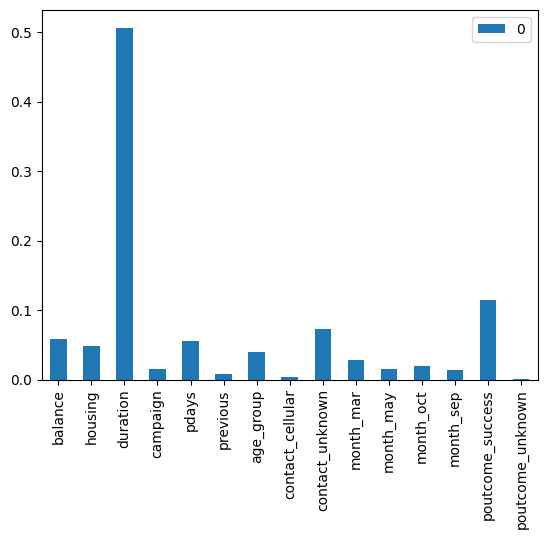

In [54]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
feat_imp = pd.DataFrame(data=gbc.feature_importances_,index=df.drop('deposit',axis=1).columns)
feat_imp.plot(kind='bar')

### Задания 6,7,8

In [55]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study()

study.optimize(optuna_rf, n_trials=20)

model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)

model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-12-22 02:59:40,959] A new study created in memory with name: no-name-89dd0636-a12a-43d7-b8db-f8b9919c4a9e
[I 2023-12-22 02:59:42,411] Trial 0 finished with value: 0.8656995788488535 and parameters: {'n_estimators': 163, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8656995788488535.
[I 2023-12-22 02:59:43,675] Trial 1 finished with value: 0.9223255081140697 and parameters: {'n_estimators': 117, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8656995788488535.
[I 2023-12-22 02:59:44,891] Trial 2 finished with value: 0.8455386545397522 and parameters: {'n_estimators': 156, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8455386545397522.
[I 2023-12-22 02:59:46,136] Trial 3 finished with value: 0.8576767362192462 and parameters: {'n_estimators': 147, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8455386545397522.
[I 2023-12-22 02:59:48,109] Trial 4 finished with value: 0.91674520892240

accuracy на тестовом наборе: 0.826
f1_score на тестовом наборе: 0.816
